## Bibliotecas

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import learning_curve
from sklearn.multioutput import MultiOutputRegressor

# Modelos
from sklearn.svm import SVR

In [3]:
X_train = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/X_train.csv', index_col='cut_index')
y_train = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/y_train.csv')
y_train.set_index(X_train.index.values, inplace=True)
X_test = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/X_test.csv', index_col='cut_index')
y_test = pd.read_csv('/content/drive/My Drive/TCC - Desenvolvimento/y_test.csv')
y_test.set_index(X_test.index.values, inplace=True)

## Adição de lags temporais

In [4]:
X_train['flute_1_lag1'] = y_train['flute_1'].shift(1).bfill()#fillna(method='bfill')
X_train['flute_1_lag2'] = y_train['flute_1'].shift(2).bfill()
X_train['flute_1_lag3'] = y_train['flute_1'].shift(3).bfill()

X_train['flute_2_lag1'] = y_train['flute_2'].shift(1).bfill()
X_train['flute_2_lag2'] = y_train['flute_2'].shift(2).bfill()
X_train['flute_2_lag3'] = y_train['flute_2'].shift(3).bfill()

X_train['flute_3_lag1'] = y_train['flute_3'].shift(1).bfill()
X_train['flute_3_lag2'] = y_train['flute_3'].shift(2).bfill()
X_train['flute_3_lag3'] = y_train['flute_3'].shift(3).bfill()

X_test['flute_1_lag1'] = y_test['flute_1'].shift(1).bfill()
X_test['flute_1_lag2'] = y_test['flute_1'].shift(2).bfill()
X_test['flute_1_lag3'] = y_test['flute_1'].shift(3).bfill()

X_test['flute_2_lag1'] = y_test['flute_2'].shift(1).bfill()
X_test['flute_2_lag2'] = y_test['flute_2'].shift(2).bfill()
X_test['flute_2_lag3'] = y_test['flute_2'].shift(3).bfill()

X_test['flute_3_lag1'] = y_test['flute_3'].shift(1).bfill()
X_test['flute_3_lag2'] = y_test['flute_3'].shift(2).bfill()
X_test['flute_3_lag3'] = y_test['flute_3'].shift(3).bfill()

In [5]:
# Ferramenta 1
X_train_C1 = X_train.iloc[:315, :]
y_train_C1 = y_train.iloc[:315, :]

# Ferramenta 2
X_train_C2 = X_train.iloc[315:, :]
y_train_C2 = y_train.iloc[315:, :]

# Ferramenta 3
X_test_C6 = X_test.iloc[:315, :]
y_test_C6 = y_test.iloc[:315, :]

## SVR com todas as features (final)

In [6]:
selected_features = X_train_C1.columns.to_list()

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Definindo os parâmetros para o GridSearchCV com Support Vector Regressor
param_grid = {
    'regressor__estimator__C': [0.1, 1, 10],                     # Parâmetro de regularização
    'regressor__estimator__kernel': ['linear', 'rbf', 'poly'],    # Tipo de kernel
    'regressor__estimator__gamma': ['scale', 'auto'],             # Parâmetro de kernel para 'rbf' e 'poly'
    'regressor__estimator__epsilon': [0.01, 0.1, 0.5]            # Margem de erro
}

# Definindo o pipeline para cada ferramenta com Support Vector Regressor
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SVR()))
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1 e C2
for model, X_train_rfe, y_train, grid_search, name in [
    (grid_search_C1, X_train_C1_rfe, y_train_C1, grid_search_C1, "C1"),
    (grid_search_C2, X_train_C2_rfe, y_train_C2, grid_search_C2, "C2")
]:
    print(f"Performance em cada fold para o modelo {name}:")
    mse_folds = []
    r2_folds = []
    mape_folds = []

    for i, (train_index, test_index) in enumerate(tscv.split(X_train_rfe)):
        X_train_fold, X_test_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        grid_search.best_estimator_.fit(X_train_fold, y_train_fold)
        y_pred_fold = grid_search.best_estimator_.predict(X_test_fold)

        mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
        r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

        mse_folds.append(mse_fold)
        r2_folds.append(r2_fold)
        mape_folds.append(mape_fold)

        print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

    # Calculando a média dos folds para cada métrica
    mean_mse = np.mean(mse_folds, axis=0)
    mean_r2 = np.mean(r2_folds, axis=0)
    mean_mape = np.mean(mape_folds, axis=0)

    print(f"Média dos Folds para {name}:")
    print(f"  MSE Médio: {[round(x, 2) for x in mean_mse]}")
    print(f"  R2 Médio: {[round(x, 2) for x in mean_r2]}")
    print(f"  MAPE Médio: {[round(x, 2) for x in mean_mape]}")



Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__e

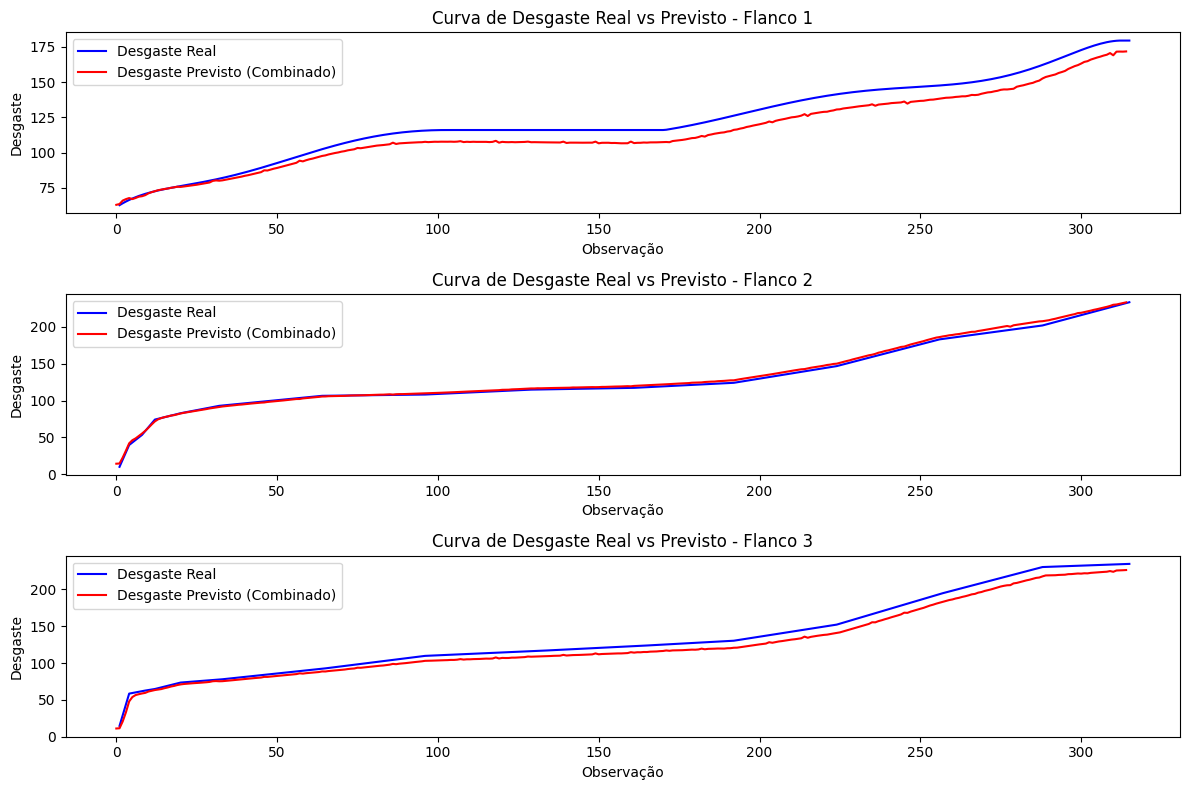

In [7]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

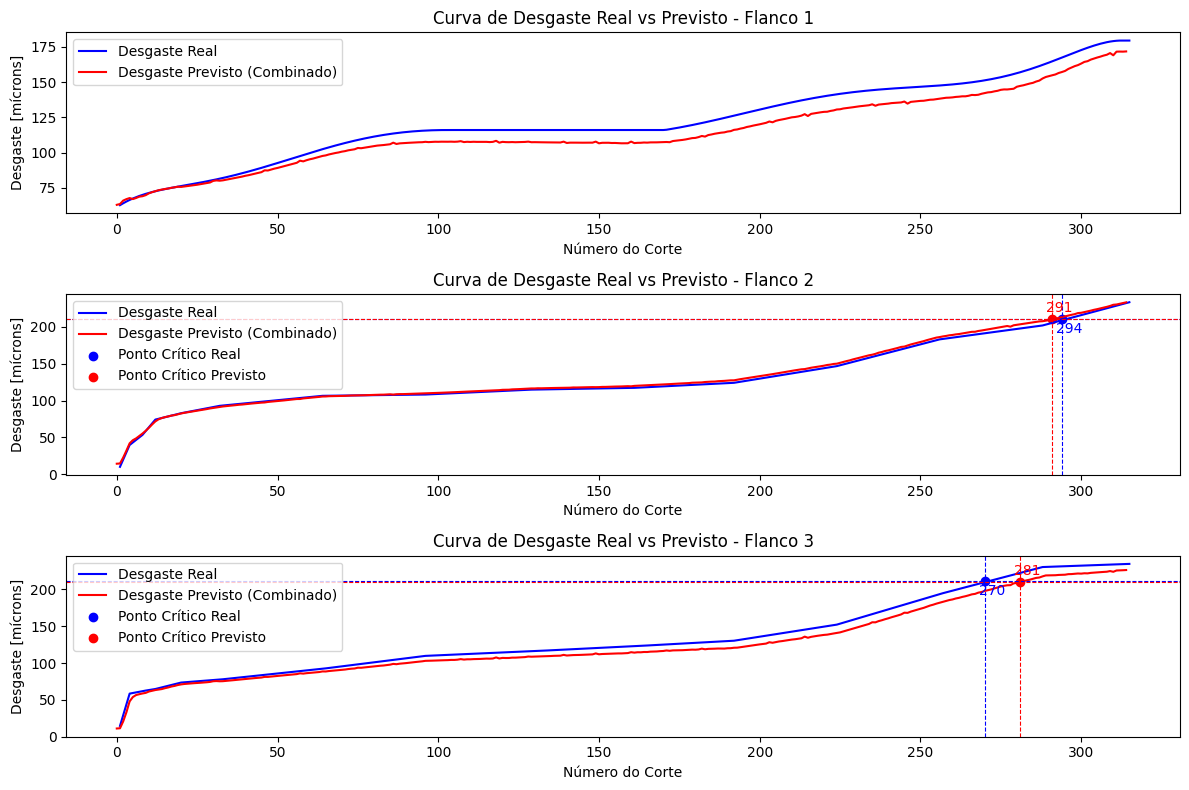

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## SVR com features temporais

In [14]:
temporal_features = ['force_x_min', 'force_x_mean', 'force_x_std', 'force_x_kurtosis', 'force_y_max', 'force_y_std', 'force_z_max',
       'force_z_min', 'force_z_std', 'force_z_skewness', 'force_z_kurtosis',
       'acc_y_std', 'acc_y_rms', 'acc_z_std', 'acc_z_rms', 'force_x_mean_lag-1', 'force_x_std_lag-1', 'force_y_std_lag-1',
       'acc_x_std_lag-1', 'acc_y_std_lag-1', 'acc_z_std_lag-1', 'flute_1_lag1',
       'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2',
       'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']

In [15]:
selected_features = temporal_features

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Definindo os parâmetros para o GridSearchCV com Support Vector Regressor
param_grid = {
    'regressor__estimator__C': [0.1, 1, 10],                     # Parâmetro de regularização
    'regressor__estimator__kernel': ['linear', 'rbf', 'poly'],    # Tipo de kernel
    'regressor__estimator__gamma': ['scale', 'auto'],             # Parâmetro de kernel para 'rbf' e 'poly'
    'regressor__estimator__epsilon': [0.01, 0.1, 0.5]            # Margem de erro
}

# Definindo o pipeline para cada ferramenta com Support Vector Regressor
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SVR()))
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1 e C2
for model, X_train_rfe, y_train, grid_search, name in [
    (grid_search_C1, X_train_C1_rfe, y_train_C1, grid_search_C1, "C1"),
    (grid_search_C2, X_train_C2_rfe, y_train_C2, grid_search_C2, "C2")
]:
    print(f"Performance em cada fold para o modelo {name}:")
    mse_folds = []
    r2_folds = []
    mape_folds = []

    for i, (train_index, test_index) in enumerate(tscv.split(X_train_rfe)):
        X_train_fold, X_test_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        grid_search.best_estimator_.fit(X_train_fold, y_train_fold)
        y_pred_fold = grid_search.best_estimator_.predict(X_test_fold)

        mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
        r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

        mse_folds.append(mse_fold)
        r2_folds.append(r2_fold)
        mape_folds.append(mape_fold)

        print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

    # Calculando a média dos folds para cada métrica
    mean_mse = np.mean(mse_folds, axis=0)
    mean_r2 = np.mean(r2_folds, axis=0)
    mean_mape = np.mean(mape_folds, axis=0)

    print(f"Média dos Folds para {name}:")
    print(f"  MSE Médio: {[round(x, 2) for x in mean_mse]}")
    print(f"  R2 Médio: {[round(x, 2) for x in mean_r2]}")
    print(f"  MAPE Médio: {[round(x, 2) for x in mean_mape]}")



Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__e

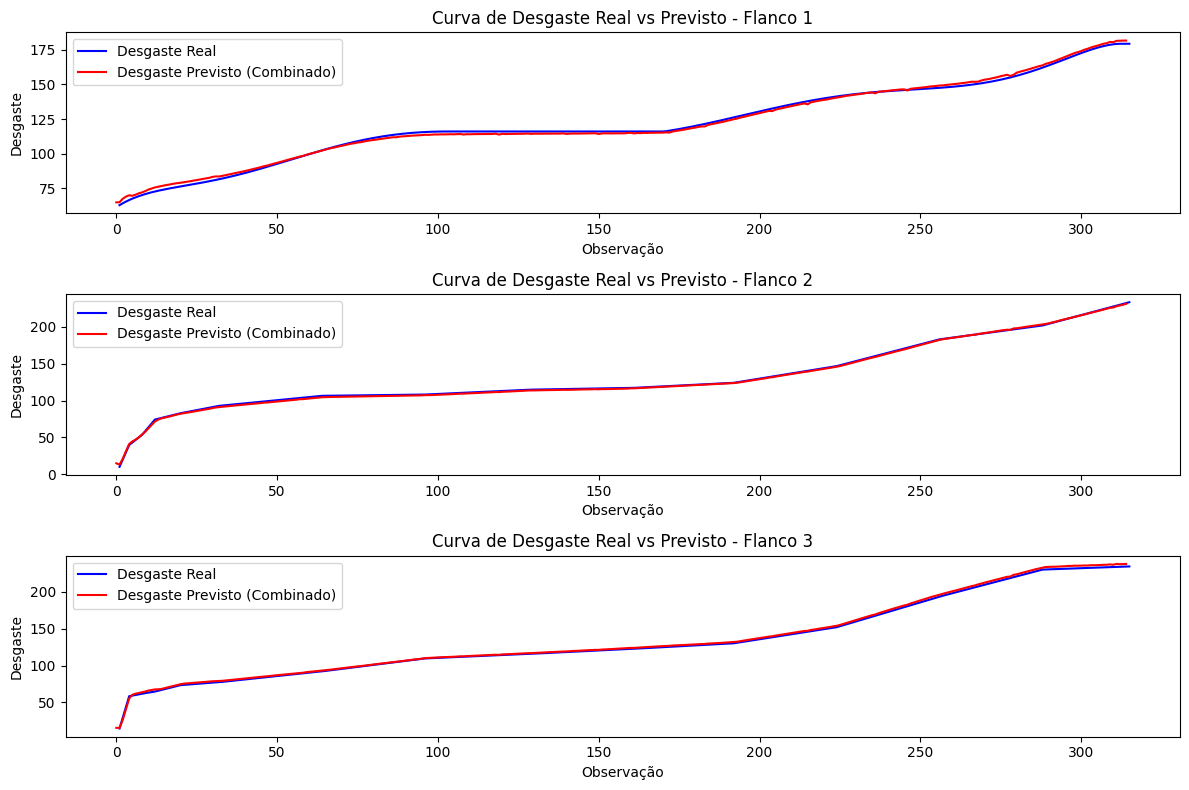

In [16]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

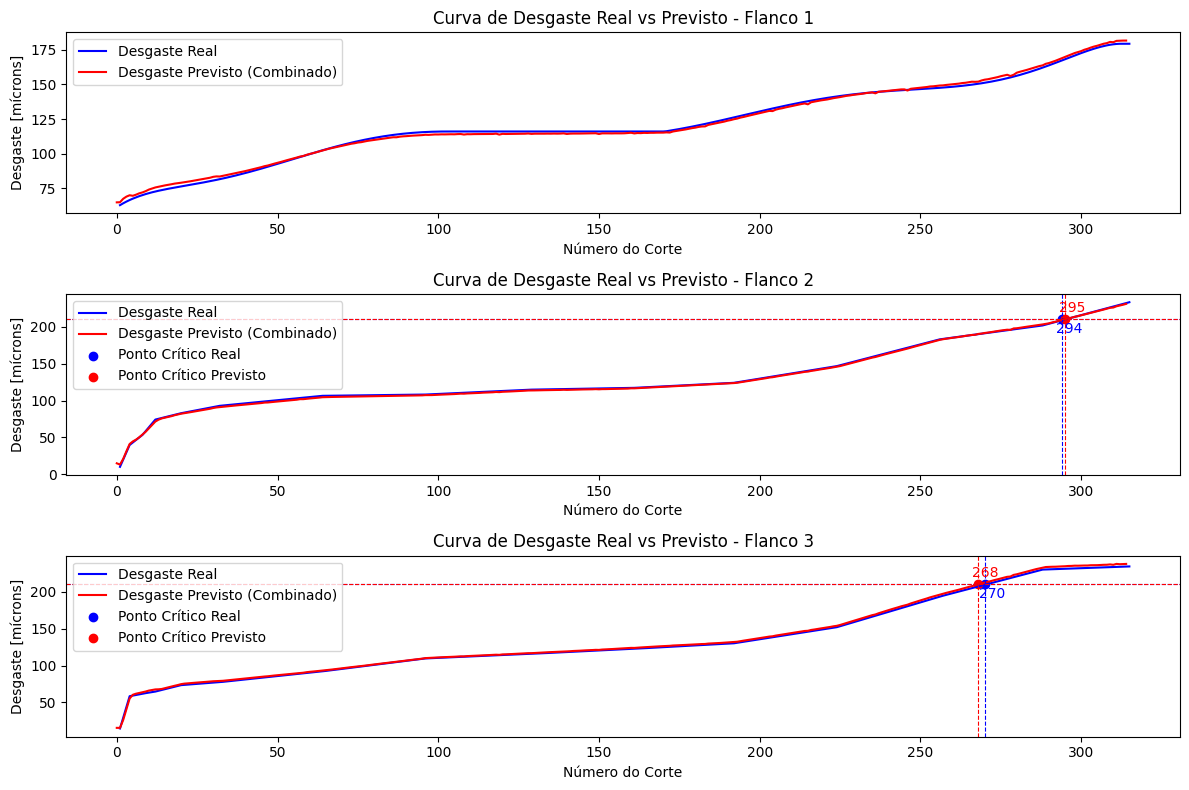

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## SVR com features de frequência

In [6]:
spectral_features = ['force_x_spectral_kurtosis',
       'force_y_spectral_kurtosis', 'force_y_spectral_skewness',
       'acc_x_spectral_centroid', 'acc_x_spectral_kurtosis',
       'acc_x_wavelet_energy_3000.0Hz', 'acc_x_wavelet_energy_1500.0Hz', 'acc_y_spectral_centroid',
       'acc_y_spectral_skewness', 'acc_y_wavelet_energy_3000.0Hz',
       'acc_y_wavelet_energy_375.0Hz',
       'acc_z_spectral_kurtosis', 'acc_z_spectral_skewness',
       'acc_z_wavelet_energy_3000.0Hz', 'acc_z_wavelet_energy_1500.0Hz', 'flute_1_lag1',
       'flute_1_lag2', 'flute_1_lag3', 'flute_2_lag1', 'flute_2_lag2',
       'flute_2_lag3', 'flute_3_lag1', 'flute_3_lag2', 'flute_3_lag3']

In [7]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

selected_features = spectral_features

# Convertendo os resultados para DataFrame e mantendo os nomes das features
X_train_C1_rfe = X_train_C1[selected_features]
X_train_C2_rfe = X_train_C2[selected_features]
X_test_C6_rfe_C1 = X_test_C6[selected_features]
X_test_C6_rfe_C2 = X_test_C6[selected_features]

# Definindo os parâmetros para o GridSearchCV com Support Vector Regressor
param_grid = {
    'regressor__estimator__C': [0.1, 1, 10],                     # Parâmetro de regularização
    'regressor__estimator__kernel': ['linear', 'rbf', 'poly'],    # Tipo de kernel
    'regressor__estimator__gamma': ['scale', 'auto'],             # Parâmetro de kernel para 'rbf' e 'poly'
    'regressor__estimator__epsilon': [0.01, 0.1, 0.5]            # Margem de erro
}

# Definindo o pipeline para cada ferramenta com Support Vector Regressor
pipeline_template = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', MultiOutputRegressor(SVR()))
])

# TimeSeriesSplit para cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Configurando o GridSearchCV para C1 e C2 com as features selecionadas
grid_search_C1 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)
grid_search_C2 = GridSearchCV(
    pipeline_template, param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=2
)

# Treinando o modelo com Cross Validation e Grid Search para C1
print("Treinando o modelo para C1 com validação cruzada...")
grid_search_C1.fit(X_train_C1_rfe, y_train_C1)

# Treinando o modelo com Cross Validation e Grid Search para C2
print("Treinando o modelo para C2 com validação cruzada...")
grid_search_C2.fit(X_train_C2_rfe, y_train_C2)

# Melhor modelo e parâmetros
print("Melhores parâmetros para C1:", grid_search_C1.best_params_)
print("Melhores parâmetros para C2:", grid_search_C2.best_params_)

# Passo 4: Avaliação nos dados de teste
# Previsões para C1 e C2
y_pred_test_C1 = grid_search_C1.predict(X_test_C6_rfe_C1)
y_pred_test_C2 = grid_search_C2.predict(X_test_C6_rfe_C2)

# Predição Combinada (Média das Previsões)
y_pred_test_combined = (y_pred_test_C1 + y_pred_test_C2) / 2

# Avaliação das métricas para a predição combinada
mse_test_combined = mean_squared_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')
r2_test_combined = r2_score(y_test_C6, y_pred_test_combined, multioutput='raw_values')
mape_test_combined = mean_absolute_percentage_error(y_test_C6, y_pred_test_combined, multioutput='raw_values')

# Exibindo as métricas de avaliação
print(f"MSE Teste (Predição Combinada): {[round(x, 2) for x in mse_test_combined]}")
print(f"MAPE Teste (Predição Combinada): {[round(x, 2) for x in mape_test_combined]}")
print(f"R2 Teste (Predição Combinada): {[round(x, 2) for x in r2_test_combined]}")

# Avaliação da performance em cada fold para C1 e C2
for model, X_train_rfe, y_train, grid_search, name in [
    (grid_search_C1, X_train_C1_rfe, y_train_C1, grid_search_C1, "C1"),
    (grid_search_C2, X_train_C2_rfe, y_train_C2, grid_search_C2, "C2")
]:
    print(f"Performance em cada fold para o modelo {name}:")
    mse_folds = []
    r2_folds = []
    mape_folds = []

    for i, (train_index, test_index) in enumerate(tscv.split(X_train_rfe)):
        X_train_fold, X_test_fold = X_train_rfe.iloc[train_index], X_train_rfe.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        grid_search.best_estimator_.fit(X_train_fold, y_train_fold)
        y_pred_fold = grid_search.best_estimator_.predict(X_test_fold)

        mse_fold = mean_squared_error(y_test_fold, y_pred_fold, multioutput='raw_values')
        r2_fold = r2_score(y_test_fold, y_pred_fold, multioutput='raw_values')
        mape_fold = mean_absolute_percentage_error(y_test_fold, y_pred_fold, multioutput='raw_values')

        mse_folds.append(mse_fold)
        r2_folds.append(r2_fold)
        mape_folds.append(mape_fold)

        print(f"Fold {i + 1}: MSE={mse_fold}, R2={r2_fold}, MAPE={mape_fold}")

    # Calculando a média dos folds para cada métrica
    mean_mse = np.mean(mse_folds, axis=0)
    mean_r2 = np.mean(r2_folds, axis=0)
    mean_mape = np.mean(mape_folds, axis=0)

    print(f"Média dos Folds para {name}:")
    print(f"  MSE Médio: {[round(x, 2) for x in mean_mse]}")
    print(f"  R2 Médio: {[round(x, 2) for x in mean_r2]}")
    print(f"  MAPE Médio: {[round(x, 2) for x in mean_mape]}")



Treinando o modelo para C1 com validação cruzada...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__epsilon=0.01, regressor__estimator__gamma=scale, regressor__estimator__kernel=linear; total time=   0.0s
[CV] END regressor__estimator__C=0.1, regressor__estimator__e

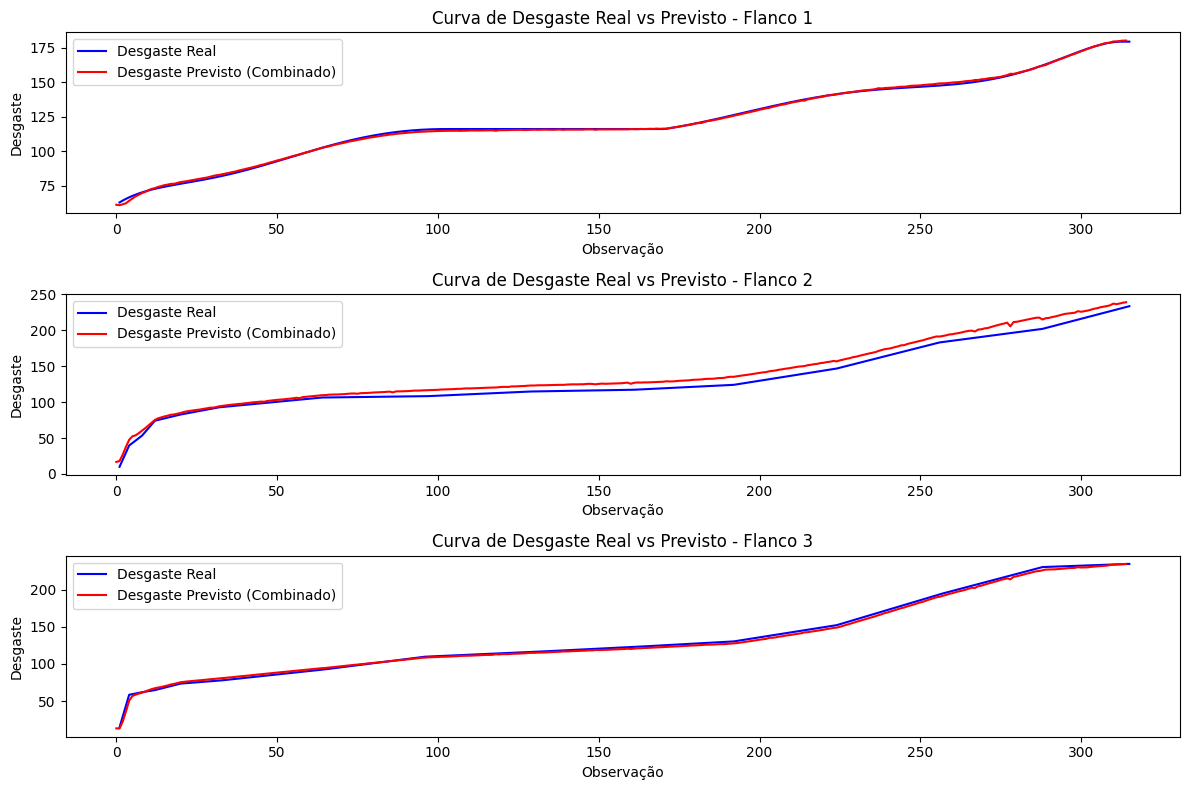

In [8]:
# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i + 1)

    # Usando .iloc para acessar as colunas específicas com base em índices
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color='blue')  # Dataset de teste y_test_C6
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color='red')

    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

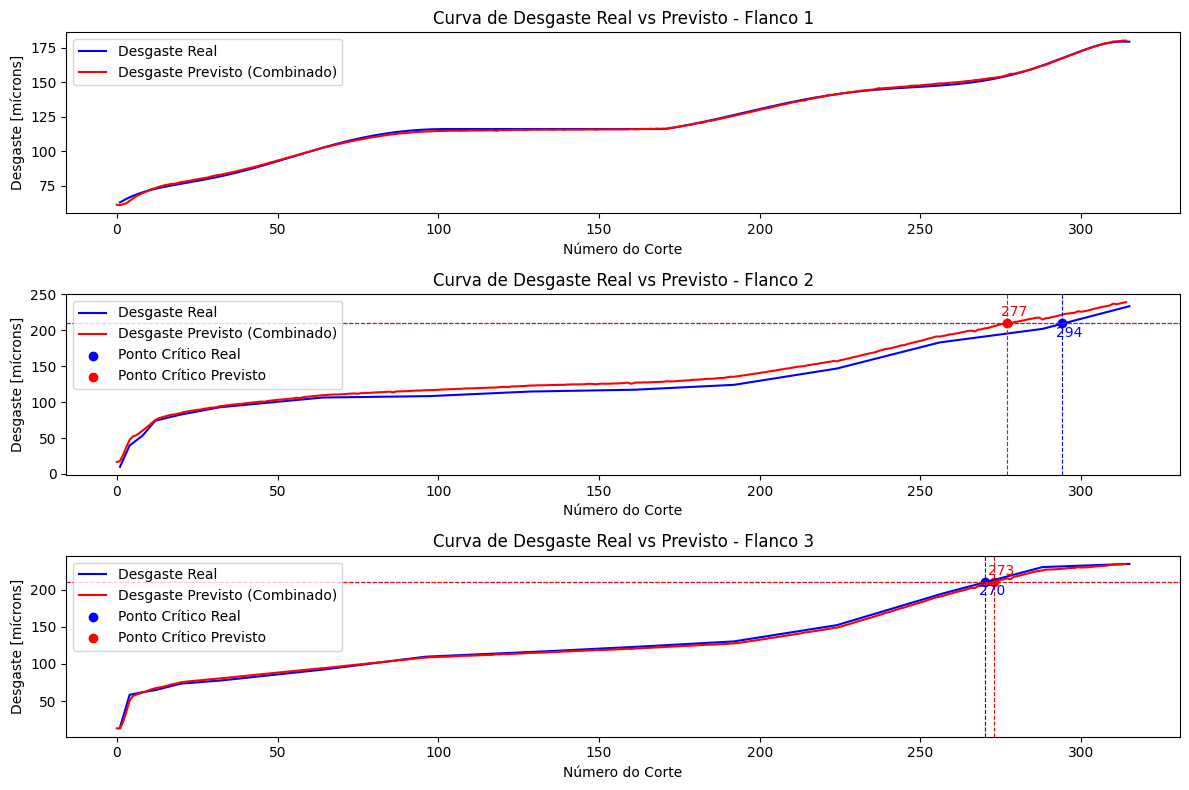

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Suponha que y_pred_test_combined e y_test_C6 já sejam definidos:
# - y_pred_test_combined: matriz numpy com previsões de desgaste (linhas = observações, colunas = flancos).
# - y_test_C6: DataFrame com valores reais de desgaste (linhas = observações, colunas = flancos).

# Define o valor crítico de desgaste
desgaste_critico = 210

# Cores para as curvas e pontos críticos
cores_pred = ['red', 'red', 'red']
cores_real = ['blue', 'blue', 'blue']

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))

for i in range(3):  # Para cada flanco (coluna)
    # Ponto crítico para o dataset de previsões (y_pred_test_combined)
    indices_criticos_pred = np.where(y_pred_test_combined[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_pred) > 0:
        indice_critico_pred = indices_criticos_pred[0]
        valor_critico_pred = y_pred_test_combined[indice_critico_pred, i]
    else:
        indice_critico_pred = 315
        valor_critico_pred = 0

    # Ponto crítico para o dataset real (y_test_C6)
    indices_criticos_real = np.where(y_test_C6.iloc[:, i] >= desgaste_critico)[0]
    if len(indices_criticos_real) > 0:
        indice_critico_real = indices_criticos_real[0]
        valor_critico_real = y_test_C6.iloc[indice_critico_real, i]
    else:
        indice_critico_real = 315
        valor_critico_real = 0

    # Subplot para o flanco atual
    plt.subplot(3, 1, i + 1)

    # Gráficos das curvas de desgaste real e previsto
    plt.plot(y_test_C6.iloc[:, i], label='Desgaste Real', color=cores_real[i])  # Dataset de teste (real)
    plt.plot(y_pred_test_combined[:, i], label='Desgaste Previsto (Combinado)', color=cores_pred[i])  # Previsões

    # Adiciona o ponto crítico para valores reais
    if indice_critico_real < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_real, valor_critico_real, color=cores_real[i], label='Ponto Crítico Real')
        plt.axhline(y=valor_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_real, color=cores_real[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_real}",  # Texto da anotação
                     (indice_critico_real, valor_critico_real),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, -10), ha='center', color=cores_real[i])  # Posição do texto

    # Adiciona o ponto crítico para previsões
    if indice_critico_pred < 315:  # Apenas plota o ponto se não for o padrão
        plt.scatter(indice_critico_pred, valor_critico_pred, color=cores_pred[i], label='Ponto Crítico Previsto')
        plt.axhline(y=valor_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.axvline(x=indice_critico_pred, color=cores_pred[i], linestyle='--', linewidth=0.8)
        plt.annotate(f"{indice_critico_pred}",  # Texto da anotação
                     (indice_critico_pred, valor_critico_pred),  # Coordenadas do ponto
                     textcoords="offset points", xytext=(5, 5), ha='center', color=cores_pred[i])  # Posição do texto

    # Personalização do gráfico
    plt.xlabel("Número do Corte")
    plt.ylabel("Desgaste [mícrons]")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

# Ajusta o layout para evitar sobreposição
plt.tight_layout()
plt.show()

## Função de treinamento e avaliação default

In [ ]:
# Ajuste esse código aos dados de treino e teste, separados para cada ferramenta (C1 e C2).
# Supondo que temos X_train_C1, X_train_C2, y_train_C1, y_train_C2 e os equivalentes para teste

# Função para treinar e avaliar o modelo usando MultiOutputRegressor com SVR
def train_and_evaluate(X_train, y_train, X_test, y_test, params):
    # Definir a pipeline com o MultiOutputRegressor usando SVRegressor
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', MultiOutputRegressor(SVR(**params)))
    ])

    # Treine o modelo para as múltiplas saídas
    pipeline.fit(X_train, y_train)

    # Previsões para treino e teste
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    # Cálculo das métricas de avaliação para cada coluna de target
    for i in range(y_train.shape[1]):
        mse_train = mean_squared_error(y_train.iloc[:, i], y_pred_train[:, i])
        mse_test = mean_squared_error(y_test.iloc[:, i], y_pred_test[:, i])
        mape_test = mean_absolute_percentage_error(y_test.iloc[:, i], y_pred_test[:, i])
        r2_test = r2_score(y_test.iloc[:, i], y_pred_test[:, i])

        print(f"Flanco {i+1} - MSE Treino: {mse_train:.2f}, MSE Teste: {mse_test:.2f}, MAPE Teste: {mape_test:.2f}, R² Teste: {r2_test:.2f}")

    return pipeline, y_pred_train, y_pred_test

In [ ]:
# Parâmetros iniciais para LightGBM (ajuste conforme necessário)
params = {
    'kernel': 'linear',
    'C': 1.0,
    'epsilon': 0.1
}

## Funçao de treinamento e avaliação com GridSearch e TimeSeries Split

In [ ]:
# Função para treinar e avaliar o modelo
def train_and_evaluate_svr(X_train, y_train, X_test, y_test, param_grid):
    # Define o TimeSeriesSplit para manter a sequência temporal nos dados
    tscv = TimeSeriesSplit(n_splits=5)

    # Configuração do GridSearch com TimeSeriesSplit
    grid_search = GridSearchCV(
        estimator=Pipeline([
            ('model', MultiOutputRegressor(SVR()))
        ]),
        param_grid=param_grid,
        cv=tscv,  # Usa TimeSeriesSplit para manter a ordem dos dados
        scoring='neg_mean_squared_error',  # Métrica de avaliação
        verbose=2,
        n_jobs=-1
    )

    # Ajuste no conjunto de treino
    grid_search.fit(X_train, y_train)

    # Recupera o melhor modelo e os melhores hiperparâmetros
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print("Melhores hiperparâmetros encontrados:", best_params)

    # Previsões no conjunto de treino e teste
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Avaliação no conjunto de treino
    mse_train = mean_squared_error(y_train, y_pred_train, multioutput='raw_values')
    mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train, multioutput='raw_values')
    print(f"MSE Treino: {mse_train}")
    print(f"MAPE Treino: {mape_train}")
    print(f"R² Treino: {r2_train}")

    # Avaliação no conjunto de teste
    mse_test = mean_squared_error(y_test, y_pred_test, multioutput='raw_values')
    mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test, multioutput='raw_values')
    print(f"MSE Teste: {mse_test}")
    print(f"MAPE Teste: {mape_test}")
    print(f"R² Teste: {r2_test}")

    # Retorna o modelo treinado e as previsões para treino e teste
    return best_model, y_pred_train, y_pred_test

# Parâmetros para testar no GridSearch
param_grid = {
    'model__estimator__C': [0.1, 1, 10],
    'model__estimator__epsilon': [0.01, 0.1, 0.5],
    'model__estimator__kernel': ['linear', 'rbf']
}

## SVR com todas as features

In [ ]:
# Treinar para C1 e C2 e combinar predições

### Sem grid search
model_C1, y_pred_train_C1, y_pred_test_C1 = train_and_evaluate(X_train_C1, y_train_C1, X_test, y_test, params)
model_C2, y_pred_train_C2, y_pred_test_C2 = train_and_evaluate(X_train_C2, y_train_C2, X_test, y_test, params)

### Com grid search
# model_C1, y_pred_train_C1, y_pred_test_C1 = train_and_evaluate(X_train_C1, y_train_C1, X_test, y_test, param_grid)
# model_C2, y_pred_train_C2, y_pred_test_C2 = train_and_evaluate(X_train_C2, y_train_C2, X_test, y_test, param_grid)

Flanco 1 - MSE Treino: 6.50, MSE Teste: 100.93, MAPE Teste: 0.06, R² Teste: 0.87
Flanco 2 - MSE Treino: 5.05, MSE Teste: 255.47, MAPE Teste: 0.13, R² Teste: 0.86
Flanco 3 - MSE Treino: 4.49, MSE Teste: 34.52, MAPE Teste: 0.05, R² Teste: 0.99
Flanco 1 - MSE Treino: 68.17, MSE Teste: 35.30, MAPE Teste: 0.04, R² Teste: 0.95
Flanco 2 - MSE Treino: 70.85, MSE Teste: 46.35, MAPE Teste: 0.06, R² Teste: 0.97
Flanco 3 - MSE Treino: 82.00, MSE Teste: 250.03, MAPE Teste: 0.13, R² Teste: 0.90


In [ ]:
# Média das previsões
y_pred_test_final = (y_pred_test_C1 + y_pred_test_C2) / 2

mse_test_final = mean_squared_error(y_test, y_pred_test_final, multioutput='raw_values')
mape_test_final = mean_absolute_percentage_error(y_test, y_pred_test_final, multioutput='raw_values')
r2_test_final = r2_score(y_test, y_pred_test_final, multioutput='raw_values')

# Iterate through the arrays and format each element individually
print(f'MSE Teste: {[f"{x:.2f}" for x in mse_test_final]}, '
      f'MAPE Teste: {[f"{x:.2f}" for x in mape_test_final]}, '
      f'R² Teste: {[f"{x:.2f}" for x in r2_test_final]}')

MSE Teste: ['22.70', '71.73', '56.20'], MAPE Teste: ['0.03', '0.07', '0.06'], R² Teste: ['0.97', '0.96', '0.98']


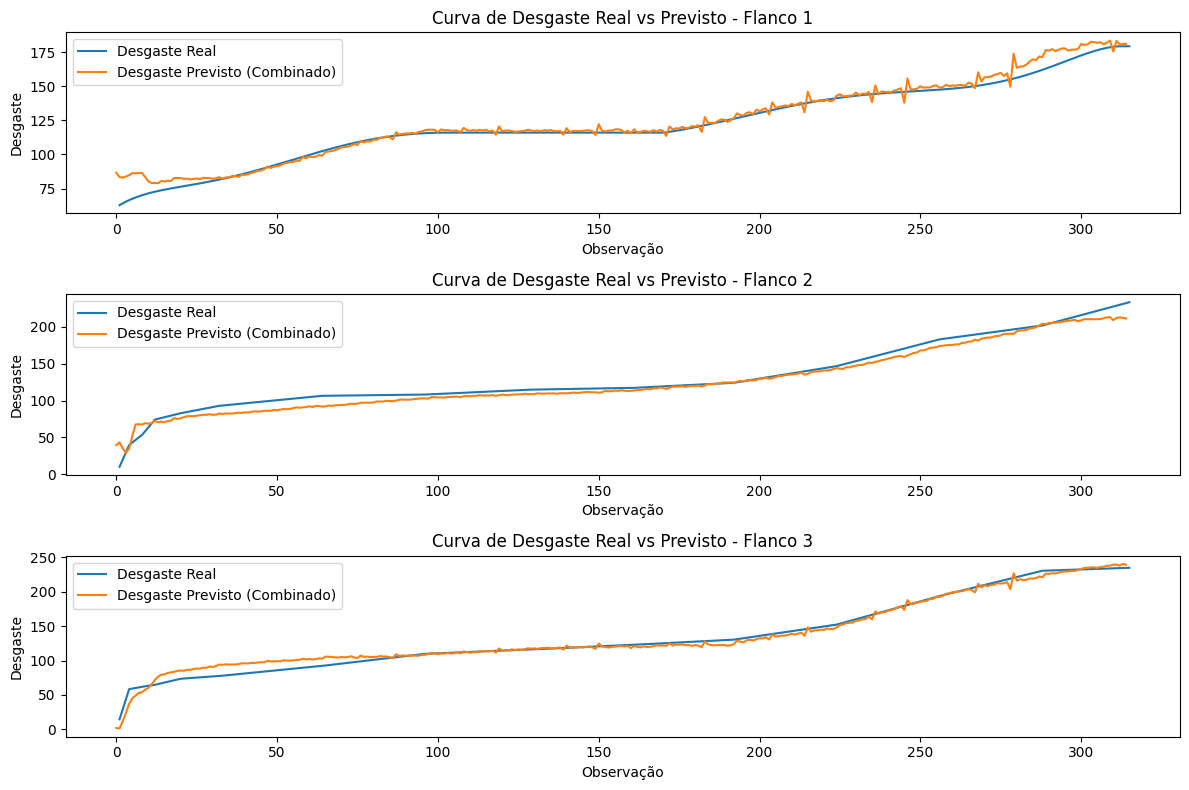

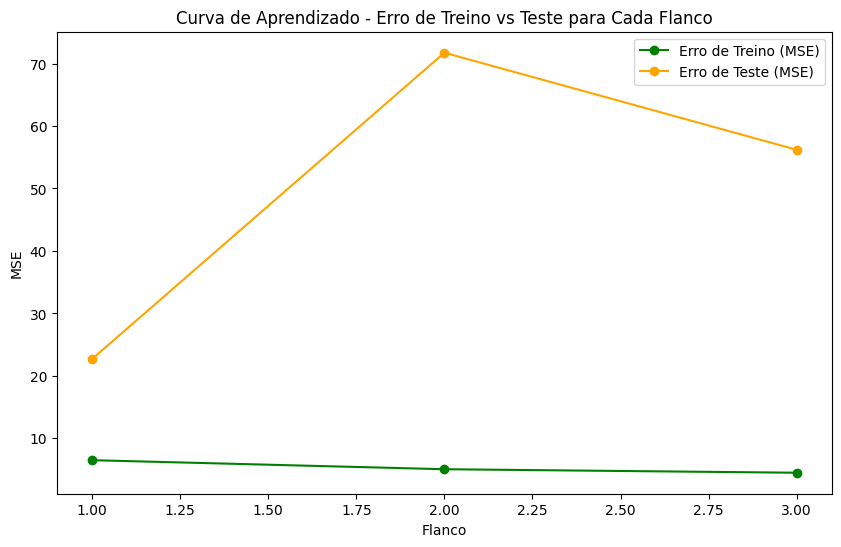

In [ ]:
# Visualizações

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    # Use .iloc for integer-location based indexing with Pandas DataFrames
    plt.plot(y_test.iloc[:, i], label='Desgaste Real')  # Changed this line
    plt.plot(y_pred_test_final[:, i], label='Desgaste Previsto (Combinado)')
    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Curva de aprendizado: erro no treino vs teste (usando MSE)
train_errors = [mean_squared_error(y_train_C1.iloc[:, i], y_pred_train_C1[:, i]) for i in range(y_train_C1.shape[1])]
test_errors = [mean_squared_error(y_test.iloc[:, i], y_pred_test_final[:, i]) for i in range(y_test.shape[1])]

plt.figure(figsize=(10, 6))
plt.plot(range(1, y_train_C1.shape[1] + 1), train_errors, label="Erro de Treino (MSE)", marker='o', color='g')
plt.plot(range(1, y_test.shape[1] + 1), test_errors, label="Erro de Teste (MSE)", marker='o', color='orange')
plt.title("Curva de Aprendizado - Erro de Treino vs Teste para Cada Flanco")
plt.xlabel("Flanco")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
#============== TESTE 2

# Treinar para C1 e C2 e combinar predições

### Sem grid search
model_C1, y_pred_train_C1, y_pred_test_C1 = train_and_evaluate(X_train_C1, y_train_C1, X_test, y_test, params)
model_C2, y_pred_train_C2, y_pred_test_C2 = train_and_evaluate(X_train_C2, y_train_C2, X_test, y_test, params)

### Com grid search
# model_C1, y_pred_train_C1, y_pred_test_C1 = train_and_evaluate(X_train_C1, y_train_C1, X_test, y_test, param_grid)
# model_C2, y_pred_train_C2, y_pred_test_C2 = train_and_evaluate(X_train_C2, y_train_C2, X_test, y_test, param_grid)

Flanco 1 - MSE Treino: 0.08, MSE Teste: 4.37, MAPE Teste: 0.02, R² Teste: 0.99
Flanco 2 - MSE Treino: 0.03, MSE Teste: 367.43, MAPE Teste: 0.13, R² Teste: 0.80
Flanco 3 - MSE Treino: 0.07, MSE Teste: 495.21, MAPE Teste: 0.16, R² Teste: 0.81
Flanco 1 - MSE Treino: 70.24, MSE Teste: 108.88, MAPE Teste: 0.08, R² Teste: 0.86
Flanco 2 - MSE Treino: 67.71, MSE Teste: 43.68, MAPE Teste: 0.05, R² Teste: 0.98
Flanco 3 - MSE Treino: 47.54, MSE Teste: 115.63, MAPE Teste: 0.09, R² Teste: 0.96


In [ ]:
# Média das previsões
y_pred_test_final = (y_pred_test_C1 + y_pred_test_C2) / 2

mse_test_final = mean_squared_error(y_test, y_pred_test_final, multioutput='raw_values')
mape_test_final = mean_absolute_percentage_error(y_test, y_pred_test_final, multioutput='raw_values')
r2_test_final = r2_score(y_test, y_pred_test_final, multioutput='raw_values')

# Iterate through the arrays and format each element individually
print(f'MSE Teste: {[f"{x:.2f}" for x in mse_test_final]}, '
      f'MAPE Teste: {[f"{x:.2f}" for x in mape_test_final]}, '
      f'R² Teste: {[f"{x:.2f}" for x in r2_test_final]}')

MSE Teste: ['26.09', '152.88', '52.68'], MAPE Teste: ['0.04', '0.09', '0.05'], R² Teste: ['0.97', '0.92', '0.98']


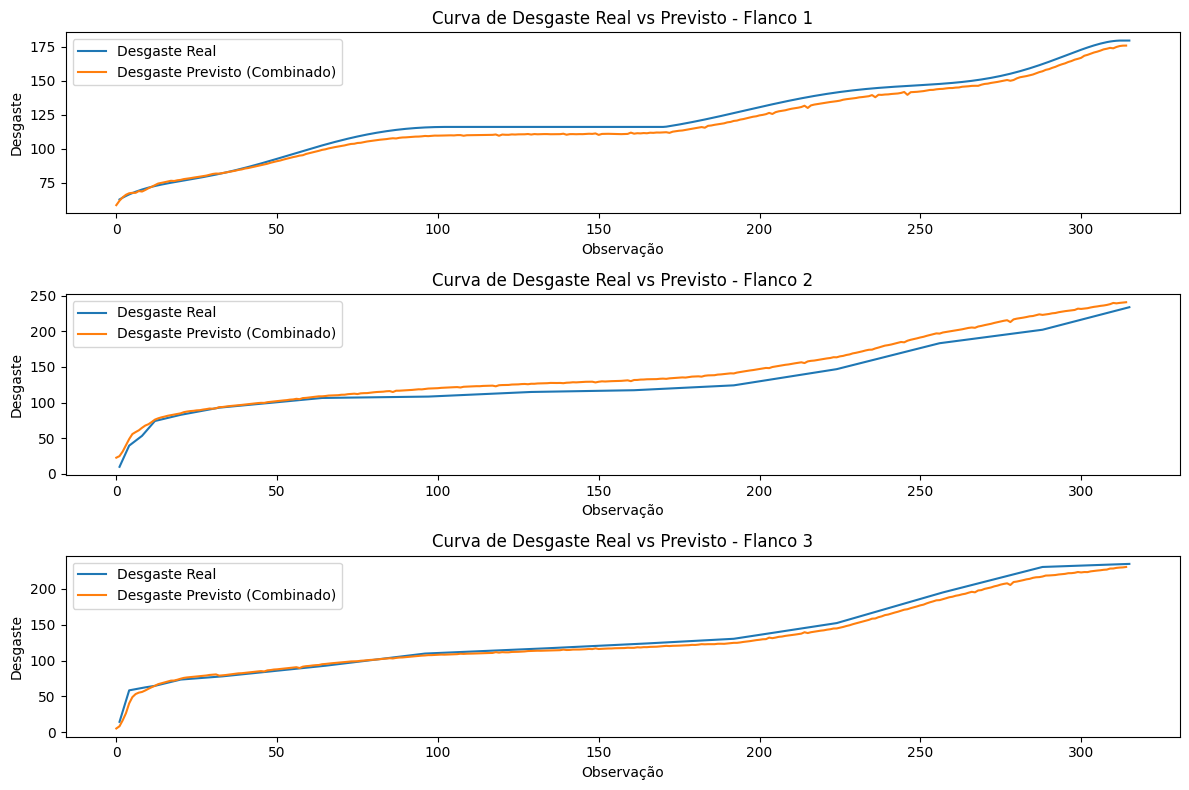

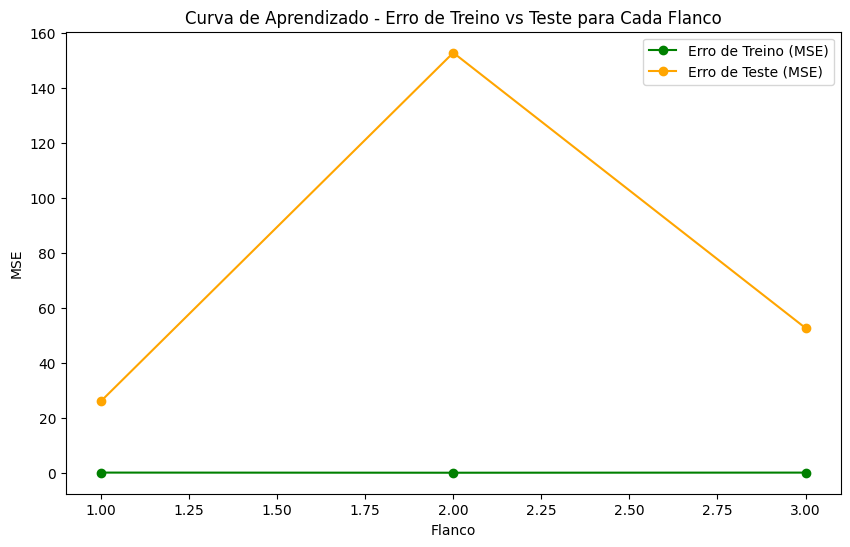

In [ ]:
# Visualizações

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    # Use .iloc for integer-location based indexing with Pandas DataFrames
    plt.plot(y_test.iloc[:, i], label='Desgaste Real')  # Changed this line
    plt.plot(y_pred_test_final[:, i], label='Desgaste Previsto (Combinado)')
    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Curva de aprendizado: erro no treino vs teste (usando MSE)
train_errors = [mean_squared_error(y_train_C1.iloc[:, i], y_pred_train_C1[:, i]) for i in range(y_train_C1.shape[1])]
test_errors = [mean_squared_error(y_test.iloc[:, i], y_pred_test_final[:, i]) for i in range(y_test.shape[1])]

plt.figure(figsize=(10, 6))
plt.plot(range(1, y_train_C1.shape[1] + 1), train_errors, label="Erro de Treino (MSE)", marker='o', color='g')
plt.plot(range(1, y_test.shape[1] + 1), test_errors, label="Erro de Teste (MSE)", marker='o', color='orange')
plt.title("Curva de Aprendizado - Erro de Treino vs Teste para Cada Flanco")
plt.xlabel("Flanco")
plt.ylabel("MSE")
plt.legend()
plt.show()

## SVR com features pré-selecionadas

In [ ]:
# Treinar para C1 e C2 e combinar predições
model_C1, y_pred_train_C1, y_pred_test_C1 = train_and_evaluate(X_train_C1, y_train_C1, X_test, y_test, param_grid)
model_C2, y_pred_train_C2, y_pred_test_C2 = train_and_evaluate(X_train_C2, y_train_C2, X_test, y_test, param_grid)

In [ ]:
# Média das previsões
y_pred_test_final = (y_pred_test_C1 + y_pred_test_C2) / 2

mse_test_final = mean_squared_error(y_test, y_pred_test_final, multioutput='raw_values')
mape_test_final = mean_absolute_percentage_error(y_test, y_pred_test_final, multioutput='raw_values')
r2_test_final = r2_score(y_test, y_pred_test_final, multioutput='raw_values')

# Iterate through the arrays and format each element individually
print(f'MSE Teste: {[f"{x:.2f}" for x in mse_test_final]}, '
      f'MAPE Teste: {[f"{x:.2f}" for x in mape_test_final]}, '
      f'R² Teste: {[f"{x:.2f}" for x in r2_test_final]}')

In [ ]:
# Visualizações

# Gráfico de Predição Combinada vs Real para o Dataset de Teste (para cada flanco)
flancos = ['Flanco 1', 'Flanco 2', 'Flanco 3']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i + 1)
    # Use .iloc for integer-location based indexing with Pandas DataFrames
    plt.plot(y_test.iloc[:, i], label='Desgaste Real')  # Changed this line
    plt.plot(y_pred_test_final[:, i], label='Desgaste Previsto (Combinado)')
    plt.xlabel("Observação")
    plt.ylabel("Desgaste")
    plt.title(f"Curva de Desgaste Real vs Previsto - {flancos[i]}")
    plt.legend()

plt.tight_layout()
plt.show()

# 2. Curva de aprendizado: erro no treino vs teste (usando MSE)
train_errors = [mean_squared_error(y_train_C1.iloc[:, i], y_pred_train_C1[:, i]) for i in range(y_train_C1.shape[1])]
test_errors = [mean_squared_error(y_test.iloc[:, i], y_pred_test_final[:, i]) for i in range(y_test.shape[1])]

plt.figure(figsize=(10, 6))
plt.plot(range(1, y_train_C1.shape[1] + 1), train_errors, label="Erro de Treino (MSE)", marker='o', color='g')
plt.plot(range(1, y_test.shape[1] + 1), test_errors, label="Erro de Teste (MSE)", marker='o', color='orange')
plt.title("Curva de Aprendizado - Erro de Treino vs Teste para Cada Flanco")
plt.xlabel("Flanco")
plt.ylabel("MSE")
plt.legend()
plt.show()